In [20]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import datetime
from utils.es_utils import *
from utils.env_utils import *
from utils.train_utils import *
import torch.nn.functional as F
from models.Buffer import Buffer
from models.Generator import GeneratorPolicy
from models.Discriminator import Discriminator
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt

In [21]:
# Training Folder
path = r"..\data\pretuning"
timestamp = datetime.datetime.now().strftime("%d.%m.%Y_%H.%M")
folder_name = f"Pretuning - {timestamp}"

save_dir = os.path.join(path, folder_name)
os.makedirs(save_dir, exist_ok=True)

data_path = r"..\data\processed\pred_prey_interactions\expert_tensors\hand_labeled"
buffer_path = r"..\data\buffer"

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pred_policy = GeneratorPolicy().to(device)
pred_policy.set_parameters(init=True)

prey_policy = GeneratorPolicy().to(device)
prey_policy.set_parameters(init=True)

expert_buffer = Buffer(pred_max_length=1100, prey_max_length=34000, device=device)

In [23]:
print("Expert Buffer is empty, load data...")
pred, prey = expert_buffer.add_expert(data_path)
len_exp_pred, len_exp_prey = expert_buffer.lengths()

print("Storage of Predator Expert Buffer: ", len_exp_pred)
print("Storage of Prey Expert Buffer: ", len_exp_prey, "\n")

Expert Buffer is empty, load data...
Storage of Predator Expert Buffer:  1057
Storage of Prey Expert Buffer:  33824 



In [24]:
def pretrain_policy_with_validation(policy, expert_buffer, role, val_ratio=0.2, pred_bs=256, prey_bs=512, epochs=10, lr=1e-3, device='cpu'):
    # 1) Sample a large batch for BC
    if role == 'predator':
        batch, _ = expert_buffer.sample(pred_bs, prey_bs)
    else:
        _, batch = expert_buffer.sample(pred_bs, prey_bs)

    # 2) Split state and action
    states = batch[..., :4]           # (N, neigh, 4)
    actions = batch[:, 0, 4].squeeze()  # one true action per agent

    # 3) Build dataset and split into train/val
    dataset = TensorDataset(states, actions)
    val_size = int(len(dataset) * val_ratio)
    train_size = len(dataset) - val_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_ds, batch_size=pred_bs if role=='predator' else prey_bs, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=pred_bs if role=='predator' else prey_bs, shuffle=False)

    # 4) Move model and set up optimizer
    policy.to(device)
    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    # 5) Training loop with validation
    for epoch in range(1, epochs + 1):
        policy.train()
        total_train_loss = 0.0
        for batch_states, batch_actions in train_loader:
            batch_states = batch_states.to(device)
            batch_actions = batch_actions.to(device)

            if role == 'predator':
                pred_out = policy.forward_pred(batch_states)
            else:
                pred_out = policy.forward_prey(batch_states)

            loss = F.mse_loss(pred_out, batch_actions)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * batch_states.size(0)

        avg_train_loss = total_train_loss / train_size
        train_losses.append(avg_train_loss)

        policy.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for batch_states, batch_actions in val_loader:
                batch_states = batch_states.to(device)
                batch_actions = batch_actions.to(device)

                if role == 'predator':
                    pred_out = policy.forward_pred(batch_states)
                else:
                    pred_out = policy.forward_prey(batch_states)

                loss = F.mse_loss(pred_out, batch_actions)
                total_val_loss += loss.item() * batch_states.size(0)

        avg_val_loss = total_val_loss / val_size
        val_losses.append(avg_val_loss)

        print(f"[{role.upper()}] Epoch {epoch:02d}  Train Loss: {avg_train_loss:.6f}  Val Loss: {avg_val_loss:.6f}")

    # 6) Plot loss curves
    plt.figure()
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f"{role.capitalize()} Loss Curves")
    plt.legend()
    plt.show()

    return policy

[PREDATOR] Epoch 01  Train Loss: 0.608148  Val Loss: 0.592907
[PREDATOR] Epoch 02  Train Loss: 0.523436  Val Loss: 0.595277
[PREDATOR] Epoch 03  Train Loss: 0.492210  Val Loss: 0.474077
[PREDATOR] Epoch 04  Train Loss: 0.438521  Val Loss: 0.464743
[PREDATOR] Epoch 05  Train Loss: 0.449047  Val Loss: 0.440374
[PREDATOR] Epoch 06  Train Loss: 0.430270  Val Loss: 0.420943
[PREDATOR] Epoch 07  Train Loss: 0.419341  Val Loss: 0.395409
[PREDATOR] Epoch 08  Train Loss: 0.404267  Val Loss: 0.466409
[PREDATOR] Epoch 09  Train Loss: 0.379543  Val Loss: 0.443683
[PREDATOR] Epoch 10  Train Loss: 0.428289  Val Loss: 0.443809
[PREDATOR] Epoch 11  Train Loss: 0.413237  Val Loss: 0.391448
[PREDATOR] Epoch 12  Train Loss: 0.404975  Val Loss: 0.427999
[PREDATOR] Epoch 13  Train Loss: 0.405880  Val Loss: 0.384530
[PREDATOR] Epoch 14  Train Loss: 0.402870  Val Loss: 0.438762
[PREDATOR] Epoch 15  Train Loss: 0.401683  Val Loss: 0.382472
[PREDATOR] Epoch 16  Train Loss: 0.401224  Val Loss: 0.423812
[PREDATO

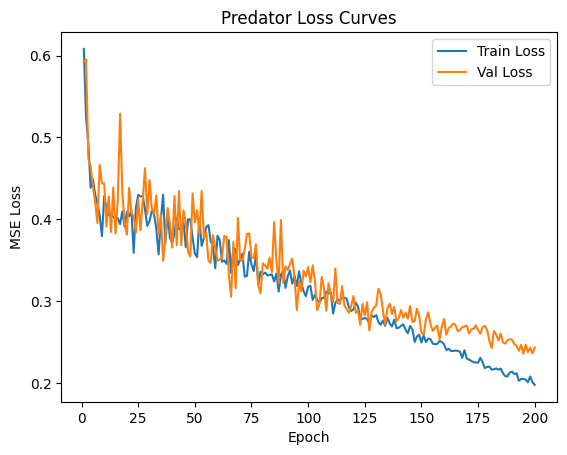

In [25]:
pred_policy = pretrain_policy_with_validation(pred_policy, expert_buffer, role='predator', val_ratio=0.2, pred_bs=512, prey_bs=1024, epochs=200, lr=1e-3, device='cpu')
torch.save(pred_policy, os.path.join(save_dir, "pred_policy.pt"))

[PREY] Epoch 01  Train Loss: 0.485228  Val Loss: 0.454935
[PREY] Epoch 02  Train Loss: 0.455675  Val Loss: 0.421153
[PREY] Epoch 03  Train Loss: 0.435590  Val Loss: 0.451248
[PREY] Epoch 04  Train Loss: 0.406191  Val Loss: 0.352723
[PREY] Epoch 05  Train Loss: 0.396226  Val Loss: 0.392979
[PREY] Epoch 06  Train Loss: 0.406242  Val Loss: 0.368974
[PREY] Epoch 07  Train Loss: 0.383589  Val Loss: 0.341765
[PREY] Epoch 08  Train Loss: 0.399948  Val Loss: 0.351236
[PREY] Epoch 09  Train Loss: 0.387469  Val Loss: 0.371250
[PREY] Epoch 10  Train Loss: 0.411839  Val Loss: 0.390145
[PREY] Epoch 11  Train Loss: 0.375286  Val Loss: 0.393244
[PREY] Epoch 12  Train Loss: 0.424147  Val Loss: 0.364548
[PREY] Epoch 13  Train Loss: 0.394787  Val Loss: 0.323877
[PREY] Epoch 14  Train Loss: 0.418995  Val Loss: 0.342411
[PREY] Epoch 15  Train Loss: 0.378833  Val Loss: 0.358128
[PREY] Epoch 16  Train Loss: 0.385647  Val Loss: 0.354790
[PREY] Epoch 17  Train Loss: 0.368410  Val Loss: 0.337160
[PREY] Epoch 1

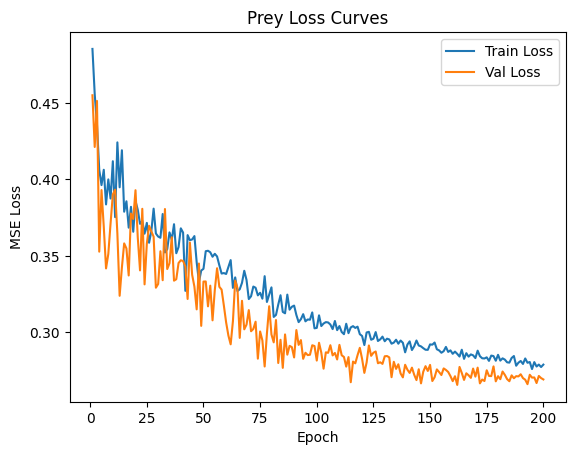

In [26]:
prey_policy = pretrain_policy_with_validation(prey_policy, expert_buffer, role='prey', val_ratio=0.2, pred_bs=512, prey_bs=1024, epochs=200, lr=1e-3, device='cpu')
torch.save(prey_policy, os.path.join(save_dir, "prey_policy.pt"))